In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint


import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdullahhashmi786","key":"fc29c4b88fd770d1a4de52ce22aa553d"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [4]:
!chmod 600 /root/.kaggle/kaggle.json
!pip install -q kaggle

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [6]:
import zipfile

with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", "r") as zip_ref:
    zip_ref.extractall("ham10000")  # Unzips to 'ham10000' folder

In [7]:
inp = '/content/ham10000'
os.listdir(inp)

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'ham10000_images_part_2',
 'ham10000_images_part_1',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_28_28_L.csv',
 'hmnist_8_8_RGB.csv']

Create the Directory Structure In these folders we will store the images that will later be fed to the Keras generators.

In [8]:
#Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

#Create Folders inside the base directory
#now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

train_dir = os.path.join(base_dir,'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir,'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir

nv = os.path.join(train_dir,'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)


# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

Create Train and Val Sets

In [9]:
df_data = pd.read_csv('/content/ham10000/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Create a stratified val set

In [10]:
#this will tell us how many images are associated with each lesion_id
df=df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [11]:
#here we identify lesion_id's that have duplicate images and those that have only one image
def identity_duplicates(x):

  unique_list = list(df['lesion_id'])

  if x in unique_list:
    return 'no_duplicates'
  else:
    return 'has_duplicates'

# Create a new column that is copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identity_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [12]:
df_data['duplicates'].value_counts()

,count
duplicates,
no_duplicates,5514
has_duplicates,4501


In [13]:
#now we filter out images that dont have duplicates
df=df_data[df_data['duplicates']=='no_duplicates']
df.shape

(5514, 8)

In [14]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y=df['dx']
_,df_val = train_test_split(df,test_size=0.17,random_state=101,stratify=y)
df_val.shape

(938, 8)

In [15]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


Create a train set that excludes images that are in the val set

In [16]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.

def identify_val_rows(x):
  # create a list of all the lesion_id's in the val set
  val_list = list(df_val['image_id'])

  if str(x) in val_list:
    return 'val'
  else:
    return 'train'

# # identify train and val rows

# create a new colum that is a copy of the image_id column

df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

#filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']

print(len(df_train))
print(len(df_val))

9077
938


In [17]:
df_train['dx'].value_counts()

,count
dx,
nv,5954
mel,1074
bkl,1024
bcc,484
akiec,301
vasc,131
df,109


In [18]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


Transfer the images into the folder

In [19]:
#Set the image_id as the index in df_data
df_data.set_index('image_id',inplace=True)

In [20]:
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train


In [21]:
base_dir ='base_dir'
train_dir = os.path.join(base_dir,'train_dir')
val_dir = os.path.join(base_dir,'val_dir')

In [22]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/ham10000/HAM10000_images_part_1')
folder_2 = os.listdir('/content/ham10000/HAM10000_images_part_2')

#GEt a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


#Transfer the train images

for image in train_list:
  fname = image+'.jpg'
  label = df_data.loc[image,'dx']

  if fname in folder_1:
    #source path to image
    src = os.path.join('/content/ham10000/HAM10000_images_part_1',fname)
    #destination path to image
    dst = os.path.join(train_dir,label,fname)
    #copy the image from source to destination
    shutil.copyfile(src,dst)

  if fname in folder_2:
    #source to path image
    src = os.path.join('/content/ham10000/HAM10000_images_part_2',fname)
    #destination path to image
    dst = os.path.join(train_dir,label,fname)
    #copy the image from source to destination
    shutil.copyfile(src,dst)


#Transfer the val images
for image in val_list:
  fname = image+'.jpg'
  label = df_data.loc[image,'dx']

  if fname in folder_1:
    #source path to image
    src = os.path.join('/content/ham10000/HAM10000_images_part_1',fname)
    #destination path to image
    dst = os.path.join(val_dir,label,fname)
    #copy the image from source to destination
    shutil.copyfile(src,dst)

  if fname in folder_2:
    #source path to image
    src = os.path.join('/content/ham10000/HAM10000_images_part_2',fname)
    #destination path to image
    dst = os.path.join(val_dir,label,fname)
    #copy the image from source to destination
    shutil.copyfile(src,dst)



In [23]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [24]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


Copy the train images into aug_dir

In [25]:
# here we are not augmenting the class nv
folder_path = 'aug_dir'
if os.path.exists(folder_path):
  shutil.rmtree(folder_path)
  print("Folder deleted.")
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
   # We are creating temporary directories here because we delete these directories later
   # create a base dir

   aug_dir = 'aug_dir'
   os.mkdir(aug_dir)
   # create a dir within the base dir to store images of the same class
   img_dir = os.path.join(aug_dir,'img_dir')
   os.mkdir(img_dir)

   # Choose a class
   img_class = item

   # list all images in that directory
   img_list = os.listdir('base_dir/train_dir/' + img_class)

   # Copy images from the class train dir to the img_dir e.g. class 'mel'
   for fname in img_list:
    #source path to image
    src = os.path.join('base_dir/train_dir/' + img_class,fname)
    # destination path to image
    dst = os.path.join(img_dir,fname)
    # copy the image from the source to the destination
    shutil.copyfile(src,dst)

   # point to a dir containing the images and not to the images themselves
   path = aug_dir
   save_path = 'base_dir/train_dir/' + img_class

   datagen = ImageDataGenerator(
       rotation_range = 180,
       width_shift_range = 0.1,
       height_shift_range = 0.1,
       zoom_range = 0.1,
       horizontal_flip = True,
       vertical_flip = True,
       #brightness_range = (0.9,1.1),
       fill_mode = 'nearest'
   )

   batch_size = 50

   aug_datagen = datagen.flow_from_directory(path,
                                            save_to_dir = save_path,
                                            save_format = 'jpg',
                                            target_size = (224,224),
                                            batch_size = batch_size)

   # Generate the augmented images and add them to the training folders

   num_aug_images_wanted = 6000 # total number of images we want to have in each class

   num_files = len(os.listdir(img_dir))
   num_batches = int(np.ceil((num_aug_images_wanted - num_files)/batch_size))


   #run the generator and create about 6000 augmneted images
   for i in range(0,num_batches):
    imgs,labels = next(aug_datagen)


   # delete temporary directory with the raw image files
   shutil.rmtree('aug_dir')



Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [26]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


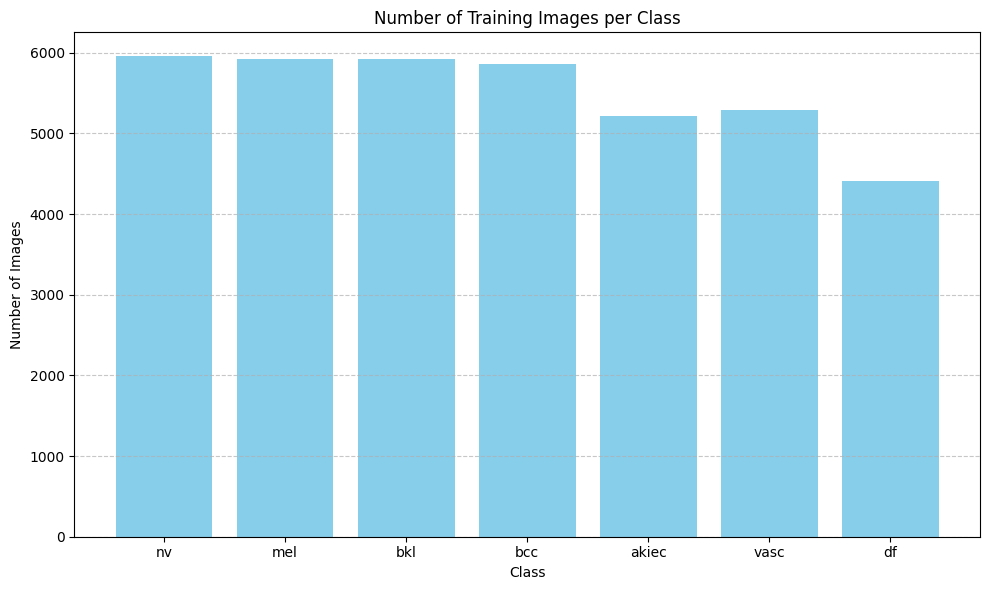

In [27]:
# Define class names and paths
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
base_path = 'base_dir/train_dir/'

# Count images in each class folder
image_counts = [len(os.listdir(os.path.join(base_path, cls))) for cls in classes]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.title('Number of Training Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [28]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


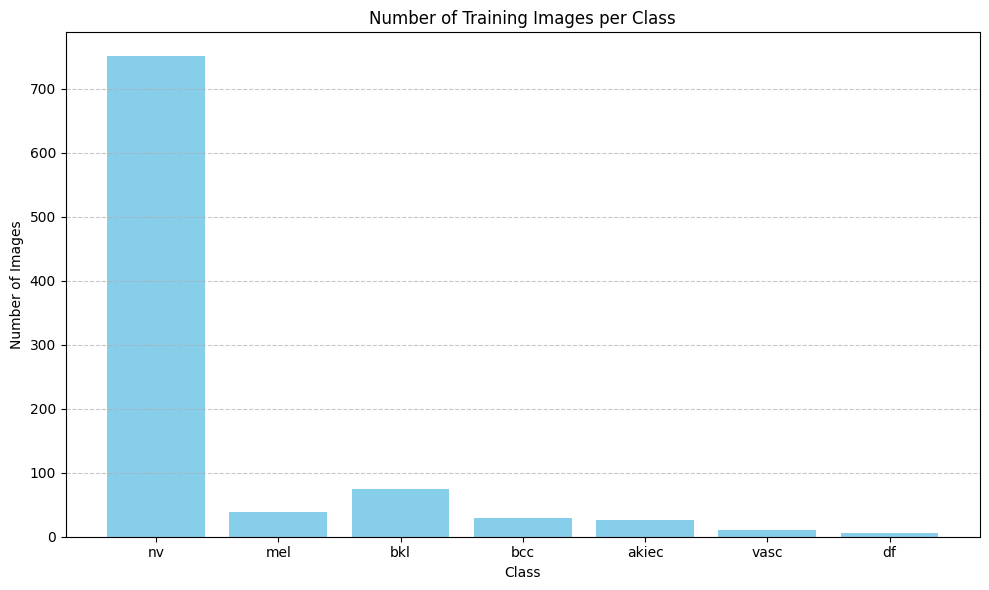

In [29]:
# Define class names and paths
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
base_path = 'base_dir/val_dir/'

# Count images in each class folder
image_counts = [len(os.listdir(os.path.join(base_path, cls))) for cls in classes]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.title('Number of Training Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


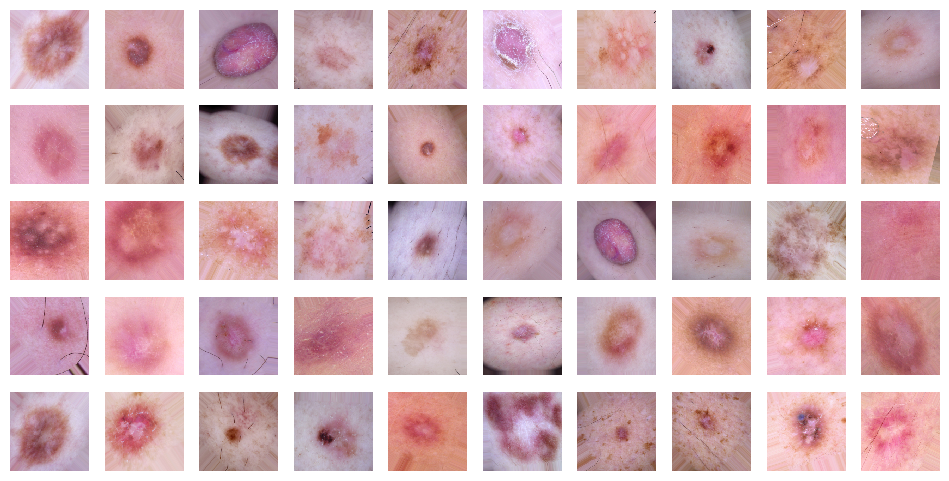

In [30]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=None) # titles=labels will display the image labels

End of DATA Preparation and
Start of Model Building

In [31]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

In [32]:
# Paths
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

In [33]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 16
val_batch_size = 16
image_size = 224

In [34]:
train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [35]:
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

In [36]:
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size, image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                           target_size=(image_size, image_size),
                                           batch_size=1,
                                           shuffle=False)


Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [37]:
# Metrics
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [38]:
# Base Model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
# Freeze base model initially
for layer in base_model.layers:
    layer.trainable = False

In [40]:
# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [41]:
# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [42]:
# Class weights (auto-computed)
train_labels = train_batches.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)
class_weights = dict(enumerate(class_weights))

In [43]:
# Callbacks
filepath = "mobilenet_skin_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=1e-6)
callbacks_list = [checkpoint, reduce_lr]

# Train initial frozen model
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.4063 - loss: 1.6084 - top_2_accuracy: 0.5916 - top_3_accuracy: 0.7299
Epoch 1: val_top_3_accuracy improved from -inf to 0.96162, saving model to mobilenet_skin_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - categorical_accuracy: 0.4067 - loss: 1.6074 - top_2_accuracy: 0.5919 - top_3_accuracy: 0.7302 - val_categorical_accuracy: 0.8209 - val_loss: 0.5157 - val_top_2_accuracy: 0.9094 - val_top_3_accuracy: 0.9616 - learning_rate: 1.0000e-04
Epoch 2/10
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6268 - loss: 1.0163 - top_2_accuracy: 0.8069 - top_3_accuracy: 0.9046
Epoch 2: val_top_3_accuracy improved from 0.96162 to 0.96695, saving model to mobilenet_skin_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - categorical_accuracy: 0.6268 - loss: 1.0162 - top_2_accuracy: 0.8069 - top_3_accuracy: 0.9046 - val_categorical_accuracy: 0.8475 - val_loss: 0.4666 - val_top_2_accuracy: 0.9328 - val

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_top_3_accuracy did not improve from 0.96695
568/568 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - categorical_accuracy: 0.7153 - loss: 0.7650 - top_2_accuracy: 0.8788 - top_3_accuracy: 0.9471 - val_categorical_accuracy: 0.8561 - val_loss: 0.4389 - val_top_2_accuracy: 0.9382 - val_top_3_accuracy: 0.9616 - learning_rate: 5.0000e-05
Epoch 6/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.7141 - loss: 0.7700 - top_2_accuracy: 0.8819 - top_3_accuracy: 0.9468
Epoch 6: val_top_3_accuracy did not improve from 0.96695

Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
568/568 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - categorical_accuracy: 0.7141 - loss: 0.7700 - top_2_accuracy: 0.8819 - top_3_accuracy: 0.9468 - val_categorical_accuracy: 0.8614 - val_loss: 0.4307 - val_top_2_accuracy: 0.9414 - val_top_3_accuracy: 0.9659 - learning_rate: 5.0000e-05
Epoch 7/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.7202 - loss: 0.7591 - 

In [44]:
# Unfreeze top 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [45]:
# Re-compile for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [46]:
# Fine-tune model
history_fine = model.fit(train_batches,
                         steps_per_epoch=train_steps,
                         class_weight=class_weights,
                         validation_data=valid_batches,
                         validation_steps=val_steps,
                         epochs=10,
                         verbose=1,
                         callbacks=callbacks_list)

Epoch 1/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5656 - loss: 1.2172 - top_2_accuracy: 0.7516 - top_3_accuracy: 0.8661
Epoch 1: val_top_3_accuracy did not improve from 0.97122
568/568 ━━━━━━━━━━━━━━━━━━━━ 52s 69ms/step - categorical_accuracy: 0.5656 - loss: 1.2169 - top_2_accuracy: 0.7516 - top_3_accuracy: 0.8661 - val_categorical_accuracy: 0.8486 - val_loss: 0.4584 - val_top_2_accuracy: 0.9264 - val_top_3_accuracy: 0.9616 - learning_rate: 1.0000e-05
Epoch 2/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6525 - loss: 0.9164 - top_2_accuracy: 0.8382 - top_3_accuracy: 0.9275
Epoch 2: val_top_3_accuracy improved from 0.97122 to 0.97335, saving model to mobilenet_skin_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - categorical_accuracy: 0.6525 - loss: 0.9163 - top_2_accuracy: 0.8383 - top_3_accuracy: 0.9275 - val_categorical_accuracy: 0.8550 - val_loss: 0.4224 - val_top_2_accuracy: 0.9382 - val_top_3_accuracy: 0.9733 - learning

In [47]:
# Save final model
model.save("mobilenet_skin_model_final.keras")

In [48]:
from tensorflow.keras.models import load_model
model = load_model("mobilenet_skin_model.keras",
                   custom_objects={'top_2_accuracy': top_2_accuracy,
                                   'top_3_accuracy': top_3_accuracy})
from tensorflow.keras.preprocessing import image
import numpy as np
img_path = '/content/base_dir/train_dir/nv/ISIC_0024352.jpg'  # <- your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)

# Get class labels
class_labels = list(train_batches.class_indices.keys())
predicted_class = class_labels[np.argmax(pred)]

print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: nv


In [49]:
model.metrics_names

['loss', 'compile_metrics']

In [50]:
#here the last epoch will be used
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches,
               steps=len(df_val))


print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - categorical_accuracy: 0.7263 - loss: 0.8023 - top_2_accuracy: 0.8731 - top_3_accuracy: 0.9348
val_loss: 0.37459254264831543
val_cat_acc: 0.8784648180007935
val_top_2_acc: 0.9509595036506653
val_top_3_acc: 0.9765458703041077


In [51]:
#Here the best epochs will be used
model.load_weights('mobilenet_skin_model.keras')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches,
               steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - categorical_accuracy: 0.7263 - loss: 0.8023 - top_2_accuracy: 0.8731 - top_3_accuracy: 0.9348
val_loss: 0.37459254264831543
val_cat_acc: 0.8784648180007935
val_top_2_acc: 0.9509595036506653
val_top_3_acc: 0.9765458703041077


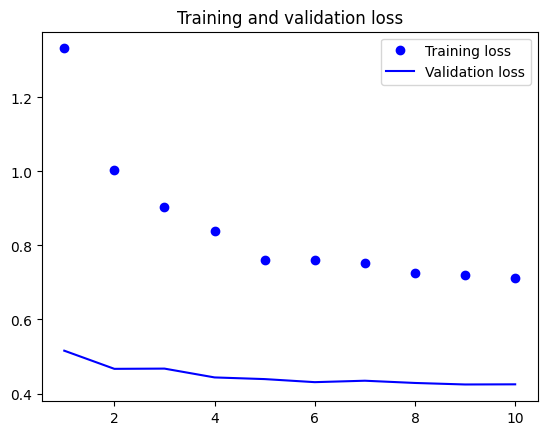

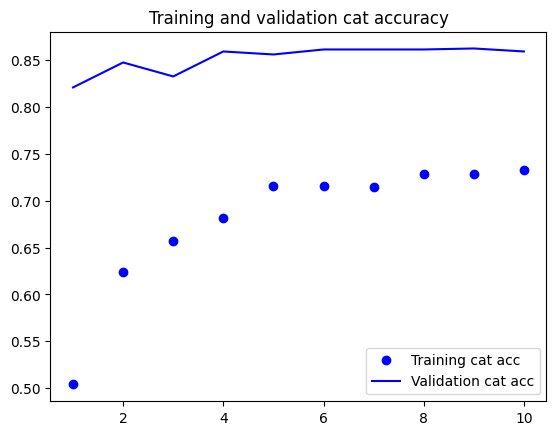

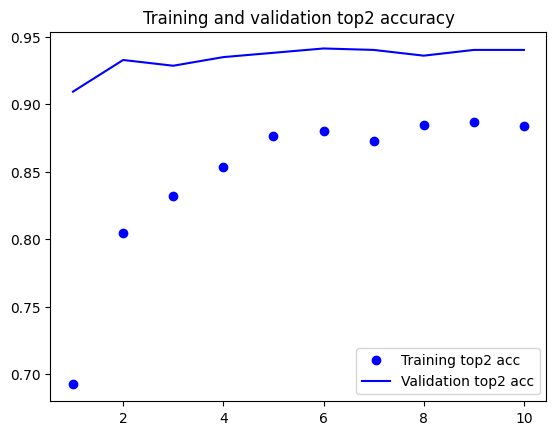

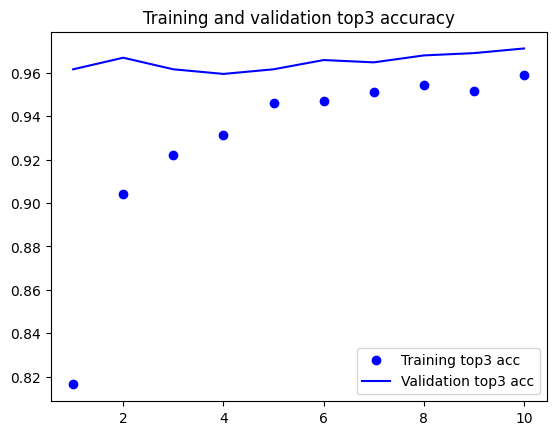

In [52]:

# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

Create a confusion matrix

In [53]:
test_labels = test_batches.classes

In [54]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [55]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [56]:
# Use predict directly:
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


In [57]:
predictions.shape

(938, 7)

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [59]:
test_labels.shape

(938,)

In [60]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [61]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  9   3   6   2   3   3   0]
 [  2  20   2   1   0   4   1]
 [  2   1  42   0   6  24   0]
 [  0   0   0   1   0   5   0]
 [  2   1   7   0  16  13   0]
 [  2   4   8   3   6 727   1]
 [  0   0   0   0   0   2   9]]


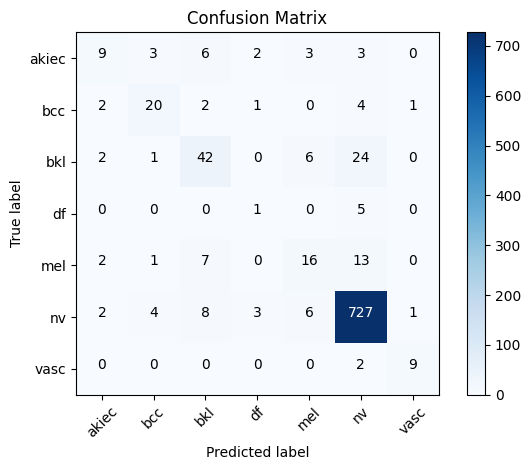

In [62]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')